# Tugas Akhir 
## Muhammad Fadhli Mubarak

# 1. Business Understanding
Pada tugas akhir kali ini, saya akan melakukan sentiment analysis terhadap suatu topik. Topik yang saya pilih adalah tentang "hasil tuntutan hukuman terhadap kasus pembunuhan berencana Brigadir J." yang sedang viral beakangan ini. Tujuan dari tugas akhir ini adalah untuk mengetahui sentimen masyarakat terhadap isu ini terutama warganet yang ada di twitter. Lalu, saya akan mengambil beberapa judul berita dengan menggunakan web scraping untuk mengetahui sentimen dari judul-judul berita terkait berdasarkan hasil dari Machine Learning model yang dibuat dari data TwitterAPI.

In [76]:
# Import packages 
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import json, tweepy, requests, re, datetime, string, nltk
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

from nltk import FreqDist
from urllib.request import Request, urlopen
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import gensim
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from numpy import array
import tqdm
from pprint import pprint

indonesia_s = stopwords.words('indonesian')
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\asus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [77]:
# Mempersiapkan token untuk menggunakan TwitterAPI

with open("token.json")as f:
  tokens = json.load(f)

bearer_token = tokens['bearer_token']
api_key = tokens['api_key']
api_key_secret = tokens['api_key_secret']
access_token = tokens['access_token']
access_token_secret = tokens['access_token_secret']

# 2. Data Collection
Data collection kali ini dibagi menjadi 2 bagian yaitu data collection untuk informasi tweet menggunakan TwitterAPI (Tweepy) dan data collection judul-judul berita menggunakan BeautifulSoup4.

Data-data ini diambil pada Kamis, 19 Januari 2023. Pengambilan data pada waktu yang berbeda dapat menyebabkan hasil data yang didapat berbeda pula.

## 2.1 TwitterAPI
Tweepy akan digunakan untuk mengumpulkan tweet-tweet mengenai penundaan pemilu selama 4 hari ke belakang, Mulai dari tanggal 18 Januari 2023 hingga 22 Januari 2023 (awalnya dari tanggal 15 namun sudah tidak bisa dirun). Hasil dari penambangan TwitterAPI akan disimpan pada DataFrame df_tweets.

In [78]:
api = tweepy.Client(bearer_token=bearer_token, wait_on_rate_limit=True)

start_date = '2023-01-18T00:00:00Z'
end_date = '2023-01-22T00:00:00Z'

query = "sambo seumur hidup -is:retweet lang:id"

response = tweepy.Paginator(api.search_recent_tweets,
                            query = query,
                            tweet_fields=['context_annotations', 'created_at'],
                            start_time = start_date,
                            end_time = end_date,
                            max_results=100
                               ).flatten()

tweets = [tweet.text.strip() for tweet in response]

In [79]:
# Menyimpan ke format .CSV
# Namun karena untuk memastikan data yang digunakan sama,
# maka line ini akan digantikan dengan membaca .csv yang sudah disimpan sebelumnya

#df_tweets = pd.DataFrame(tweets, columns=["tweets"])
#df_tweets.to_csv("data_tweet.csv",index=False)


df_tweets = pd.read_csv('data_tweet.csv', header = 0)
df_tweets

,tweets
0,Vonis hukuman penjara seumur hidup berarti sam...
1,"@asumsico penjara seumur hidup,... \n\ns&amp;k..."
2,JPU telah menuntut hukuman pada masing2 terdak...
3,@convomf Iya deh gue bingung. Dr gue msh cimit...
4,Punya pundi² seratus triliun rupiah itu bisa b...
...,...
1926,Infonya Penjahat macam LE di Penjara Seumur hi...
1927,Infonya Penjahat macam LE di Penjara Seumur hi...
1928,Infonya Penjahat macam LE di Penjara Seumur hi...
1929,@TRANS7 Penjara saja seumur hidup


## 2.2 Web scraping
BeautifulSoup4 akan digunakan untuk melakukan web scraping. Web scraping akan dilakukan pada web Kompas.com dan mengambil judul berita pada 15 halaman pertama tentang topik terkait. Hasil judul berita dari web scraping akan disimpan pada DataFrame df_news.

In [80]:
# Mendefinisikan fungsi yang dapat melakukan web scraping pada google news dengan kata kunci "sambo penjara seumur hidup"
def news(hal):
    hasil = []
    for page in range(1,hal):
        url = f'https://www.detik.com/search/searchall?query=sambo+penjara+seumur+hidup&siteid=2&sortby=time&page={page}'
        html = urlopen(url)
        data = BeautifulSoup(html, 'html.parser')
        table = data.findAll("div", {"class":"list media_rows list-berita"})
        for article in table:
            articles = article.findAll("article")
            for span in articles:
                spans = span.findAll("a")
                for box_text in spans:
                    box_texts = box_text.findAll("span", {"class":"box_text"})
                    for title in box_texts:
                        titles = title.find("h2", {"class":"title"})
                        hasil.append(titles.get_text())
                    
    df_news = pd.DataFrame(hasil, columns = ["Judul Berita"])
    df_news.to_csv("data_berita.csv",index=False)
    return df_news

In [81]:
# Web scraping hingga 15 halaman pertama pada detik.com
news(15)

,Judul Berita
0,Sambo Minta Dibebaskan dari Segala Dakwaan dan...
1,Ferdy Sambo Minta Dibebaskan di Kasus Pembunuh...
2,Pengacara Sambo Nilai Jaksa Gagal Tunjukkan Mo...
3,Curhat Sambo Lewat Pleidoi: Dituduh Bandar Jud...
4,Sambo Kutip Ayat Alkitab di Pleidoi: Kiranya T...
...,...
121,"Teks Editorial: Pengertian, Struktur, Ciri dan..."
122,Tangis Putri Candrawathi Saat Telepon Ferdy Sa...
123,Ahli Pidana UISU Percaya JPU Akan Tuntut Ferdy...
124,10 Kesaksian Bripka RR Sebelum Insiden Berdara...


In [82]:
df_news = pd.read_csv('data_berita.csv', header = 0)
df_news

,Judul Berita
0,Sambo Minta Dibebaskan dari Segala Dakwaan dan...
1,Ferdy Sambo Minta Dibebaskan di Kasus Pembunuh...
2,Pengacara Sambo Nilai Jaksa Gagal Tunjukkan Mo...
3,Curhat Sambo Lewat Pleidoi: Dituduh Bandar Jud...
4,Sambo Kutip Ayat Alkitab di Pleidoi: Kiranya T...
...,...
121,"Teks Editorial: Pengertian, Struktur, Ciri dan..."
122,Tangis Putri Candrawathi Saat Telepon Ferdy Sa...
123,Ahli Pidana UISU Percaya JPU Akan Tuntut Ferdy...
124,10 Kesaksian Bripka RR Sebelum Insiden Berdara...


# 3. Data Cleaning 

Data cleaning secara umum akan melalui beberapa tahap yaitu Case Folding, Stopwords,Word Stemming, dan penghapusan duplikat. 
Penghapusan duplikat dilakukan karena banyak sekali tweet yang berulang-ulang (spam tweet) sehingga akan menyulitkan untuk melakukan analisis sentimen nantinya.

## 3.1 Data Cleaning pada DataFrame Tweet

In [83]:
# text cleaning(lowercase,angka,tanda baca,tautan, whitespace)
def cleaning(x):
    x = x.lower().translate(str.maketrans('','',string.digits)).translate(str.maketrans("","",string.punctuation)).strip()
    return x

df_tweets['clean_tweets'] = df_tweets['tweets'].map(cleaning)

# Stemmer
stemmer = StemmerFactory().create_stemmer()
def stemming(x):
    x = stemmer.stem(x)
    return x
df_tweets['clean_tweets'] = df_tweets['clean_tweets'].map(stemming)

# Stopwords
stop = stopwords.words('indonesian')+['m','di','yg']+['penjara','umur','hidup','sambo','ferdy','brigadir']
def filter_stopwords(x):
    x = [word for word in x.split() if word not in stop]
    x = ' '.join(x)
    return x
df_tweets['clean_tweets'] = df_tweets['clean_tweets'].map(filter_stopwords)


#Drop Duplicates
df_tweets.drop_duplicates(subset ="clean_tweets",
                     keep = False, inplace = True)

print(df_tweets)

                                                 tweets  \
0     Vonis hukuman penjara seumur hidup berarti sam...   
1     @asumsico penjara seumur hidup,... \n\ns&amp;k...   
2     JPU telah menuntut hukuman pada masing2 terdak...   
3     @convomf Iya deh gue bingung. Dr gue msh cimit...   
4     Punya pundi² seratus triliun rupiah itu bisa b...   
...                                                 ...   
1926  Infonya Penjahat macam LE di Penjara Seumur hi...   
1927  Infonya Penjahat macam LE di Penjara Seumur hi...   
1928  Infonya Penjahat macam LE di Penjara Seumur hi...   
1929                  @TRANS7 Penjara saja seumur hidup   
1930  @msaid_didu Jgn selalu menyalahkan pemerintah ...   

                                           clean_tweets  
0                        vonis hukum arti sampe mati ya  
1                                   asumsico sampk laku  
2     jpu tuntut hukum dakwa bunuh rencana j fs pc r...  
3     convomf iya deh gue bingung dr gue msh cimit c...  
4

In [84]:
df_tweets = df_tweets.reset_index(drop=True)
df_tweets

,tweets,clean_tweets
0,Vonis hukuman penjara seumur hidup berarti sam...,vonis hukum arti sampe mati ya
1,"@asumsico penjara seumur hidup,... \n\ns&amp;k...",asumsico sampk laku
2,JPU telah menuntut hukuman pada masing2 terdak...,jpu tuntut hukum dakwa bunuh rencana j fs pc r...
3,@convomf Iya deh gue bingung. Dr gue msh cimit...,convomf iya deh gue bingung dr gue msh cimit c...
4,Punya pundi² seratus triliun rupiah itu bisa b...,pundi ratus triliun rupiah beli beli kepala ba...
...,...,...
1911,Infonya Penjahat macam LE di Penjara Seumur hi...,info jahat le rakyatpapuadukungpenjarakanlukas...
1912,Infonya Penjahat macam LE di Penjara Seumur hi...,info jahat le rakyatpapuadukungpenjarakanlukas...
1913,Infonya Penjahat macam LE di Penjara Seumur hi...,info jahat le papua rugi ulah gubernur rakyatp...
1914,@TRANS7 Penjara saja seumur hidup,trans


# 3.2 Data Cleaning pada DataFrame Berita

In [85]:
df_news['clean_news'] = df_news['Judul Berita'].map(cleaning)
df_news['clean_news'] = df_news['clean_news'].map(stemming)
df_news['clean_news'] = df_news['clean_news'].map(filter_stopwords)
df_news.drop_duplicates(subset ="clean_news",
                     keep = False, inplace = True)

print(df_news)

                                          Judul Berita  \
0    Sambo Minta Dibebaskan dari Segala Dakwaan dan...   
1    Ferdy Sambo Minta Dibebaskan di Kasus Pembunuh...   
2    Pengacara Sambo Nilai Jaksa Gagal Tunjukkan Mo...   
4    Sambo Kutip Ayat Alkitab di Pleidoi: Kiranya T...   
5    Sambo: Tak Terbayang, Hidup Saya Terhormat dal...   
..                                                 ...   
121  Teks Editorial: Pengertian, Struktur, Ciri dan...   
122  Tangis Putri Candrawathi Saat Telepon Ferdy Sa...   
123  Ahli Pidana UISU Percaya JPU Akan Tuntut Ferdy...   
124  10 Kesaksian Bripka RR Sebelum Insiden Berdara...   
125  2 Status Tersangka Ferdy Sambo dalam Kasus Pem...   

                                            clean_news  
0                                   bebas dakwa tuntut  
1                                    bebas bunuh yosua  
2            acara nilai jaksa gagal motif bunuh yosua  
4               kutip ayat alkitab pleidoi tuhan tobat  
5                 

# 4. Data Processing

## 4.1 Distribusi frekuensi karakter per tweet

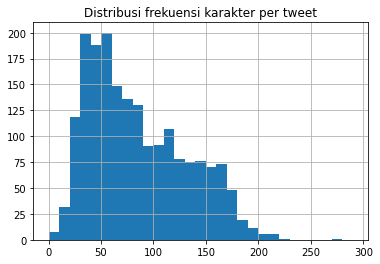

In [86]:
bin_range = np.arange(0, 300, 10)
df_tweets['clean_tweets'].str.len().hist(bins=bin_range)
plt.title('Distribusi frekuensi karakter per tweet')
plt.show()

banyaknya karakter per tweet kebanyakan berisi 30-80 karakter per tweet

## 4.2 Distribusi panjang kata per tweet

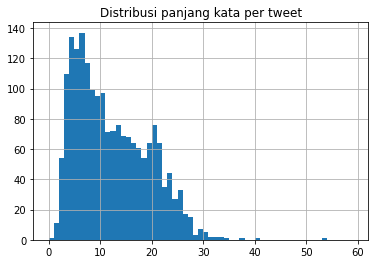

In [87]:
bin_range = np.arange(0, 60)
df_tweets['clean_tweets'].str.split().map(lambda x: len(x)).hist(bins=bin_range)
plt.title('Distribusi panjang kata per tweet')
plt.show()

panjang kata per tweet rata2 pada 3-9 kata per twwet

## 4.3 Distribusi panjang rata-rata kata per tweet

c:\Users\asus\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\asus\anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


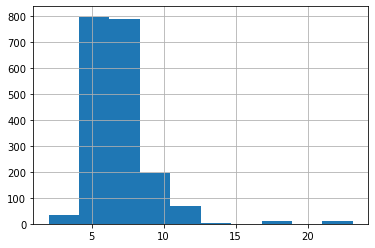

In [88]:
df_tweets['clean_tweets'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).hist()
plt.show()

panjang rata2 kata per twwet yaitu 4-8 kata

## 4.4 Distribusi kata

<FreqDist with 4978 samples and 22500 outcomes>
[('tuntut', 1215), ('hukum', 895), ('mati', 469), ('jaksa', 358), ('bunuh', 351), ('pidana', 287), ('sesuai', 237), ('ya', 234), ('yosua', 234), ('jpu', 219), ('gak', 217), ('j', 212), ('kuhp', 186), ('rencana', 174), ('dakwa', 147), ('kalo', 143), ('sampe', 131), ('vonis', 129), ('hutabarat', 128), ('laku', 122)]


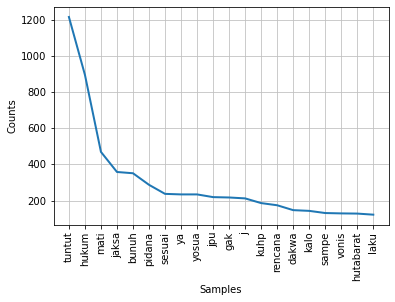

In [89]:
tweets_token = [word for tweet in df_tweets['clean_tweets'].apply(lambda x: word_tokenize(str(x))) for word in tweet]
fqdist = FreqDist(tweets_token)
print(fqdist)
most_common_word = fqdist.most_common(20)
print(most_common_word)
fqdist.plot(20,cumulative=False)
plt.show()

Dari distribusi kata yang muncul yaitu tuntut, hukum, ferdy, mati, dan jaksa merupakan 5 kata yang paling sering muncul. Hal ini karena isu terkait kasus tersebut yang sedang hangat dibahas yaitu terkait tuntutan hukuman mati atas terdakwa ferdy sambo. 

## 4.5 N-gram 

Distribusi N-gram dengan 2 sampai 4 kata akan dilakukan untuk mengetahui frasa yang sering muncul pada data tweet yang dikumpulkan.

In [90]:
# N gram 2 kata
pd.Series(nltk.ngrams(tweets_token, 2)).value_counts()[:10]

(tuntut, hukum)       251
(hukum, mati)         196
(jaksa, tuntut)       176
(bunuh, rencana)      155
(tuntut, jpu)         125
(yosua, hutabarat)     95
(jpu, tuntut)          95
(tuntut, jaksa)        89
(bunuh, yosua)         79
(tuntut, bunuh)        76
dtype: int64

In [91]:
# N gram 3 kata
pd.Series(nltk.ngrams(tweets_token, 3)).value_counts()[:10]

(jaksa, tuntut, jpu)             82
(nih, dijelasin, kejaksaanri)    66
(gak, hubung, dgn)               62
(sesuai, mitossalah, kaprah)     62
(mitossalah, kaprah, gak)        61
(kaprah, gak, kuhp)              61
(mati, gak, hubung)              60
(hubung, dgn, sesuai)            60
(dgn, sesuai, mitossalah)        60
(definisi, mati, gak)            56
dtype: int64

In [92]:
# N gram 4 kata
pd.Series(nltk.ngrams(tweets_token, 4)).value_counts()[:10]

(mitossalah, kaprah, gak, kuhp)        61
(sesuai, mitossalah, kaprah, gak)      61
(gak, hubung, dgn, sesuai)             60
(dgn, sesuai, mitossalah, kaprah)      60
(hubung, dgn, sesuai, mitossalah)      60
(mati, gak, hubung, dgn)               59
(definisi, mati, gak, hubung)          56
(kuhp, indonesia, definisi, mati)      53
(indonesia, definisi, mati, gak)       52
(kuhp, nih, dijelasin, kejaksaanri)    49
dtype: int64

## 4.6 Sentiment Analysis 

In [93]:
# Membuka kamus kata-kata yang positif dan kata-kata yang negatif
with open("./kata_positif.txt","r") as positif_file :
  positive_words = list(set(positif_file.readlines()))
with open("./kata_negatif.txt","r") as negative_file :
  negative_words = list(set(negative_file.readlines()))

In [94]:
# Melakukan analisis sentimen terhadap suatu tweet berdasarkan jumlah kata positif dan negatif yang ada di tweet
hasil = []
tweets = df_tweets['clean_tweets']
for tweet in tweets:

    tweet_clean = tweet.strip().split()
    
    good_count = 0 #nilai positif
    bad_count = 0 #nilai negatif

    for good_word in positive_words:
        count = tweet_clean.count(good_word.strip().lower())
        if count > 0:
          good_count += count

    for bad_word in negative_words:
        count = tweet_clean.count(bad_word.strip().lower())
        if count > 0:
          bad_count += count
    
    hasil.append(good_count - bad_count)
    

In [95]:
sentiments = ["positif" if sentimen > 0 else ("netral" if sentimen == 0 else "negatif") for sentimen in hasil]
df_tweets["sentiment"] = sentiments

In [96]:
print (f'''
Mean: {np.mean(hasil)}
Median: {np.median(hasil)}
quartil awal: {np.quantile(hasil,0.25)}
quartil akhir: {np.quantile(hasil,0.75)}
Standar deviasi: {np.std(hasil)}     
''')


Mean: -0.3903966597077244
Median: 0.0
quartil awal: -1.0
quartil akhir: 0.0
Standar deviasi: 1.2429305936435662     



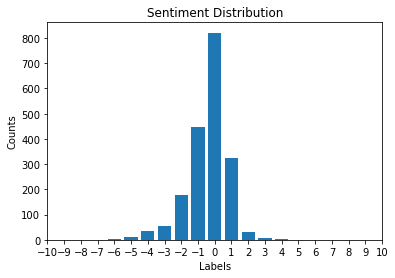

In [97]:
c = Counter(hasil)

plt.bar(c.keys(), c.values())
plt.title(f'Sentiment Distribution')
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.xlim([-10, 10])
plt.xticks(np.arange(-10, 11, 1.0))
plt.show()

In [98]:
df_tweets

,tweets,clean_tweets,sentiment
0,Vonis hukuman penjara seumur hidup berarti sam...,vonis hukum arti sampe mati ya,netral
1,"@asumsico penjara seumur hidup,... \n\ns&amp;k...",asumsico sampk laku,netral
2,JPU telah menuntut hukuman pada masing2 terdak...,jpu tuntut hukum dakwa bunuh rencana j fs pc r...,negatif
3,@convomf Iya deh gue bingung. Dr gue msh cimit...,convomf iya deh gue bingung dr gue msh cimit c...,negatif
4,Punya pundi² seratus triliun rupiah itu bisa b...,pundi ratus triliun rupiah beli beli kepala ba...,negatif
...,...,...,...
1911,Infonya Penjahat macam LE di Penjara Seumur hi...,info jahat le rakyatpapuadukungpenjarakanlukas...,negatif
1912,Infonya Penjahat macam LE di Penjara Seumur hi...,info jahat le rakyatpapuadukungpenjarakanlukas...,negatif
1913,Infonya Penjahat macam LE di Penjara Seumur hi...,info jahat le papua rugi ulah gubernur rakyatp...,negatif
1914,@TRANS7 Penjara saja seumur hidup,trans,netral


In [99]:
df_tweets['sentiment'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

netral     42.8%
negatif    37.9%
positif    19.2%
Name: sentiment, dtype: object

Dari hasil sentimen analisis menggunakan kamus kata positif dan kata negatif, kebanyakan tweet memiliki sentimen netral namun cenderung lebih banyak yang mengarah ke sentimen negatif dibandingkan dengan sentimen positif. Dapat disimpulkan sentimen terkait isu tersebut adalah lebih ke negatif dan tidak baik.

## 4.7 Topic analysis 

Analisis topik akan dilakukan untuk mengetahui secara lebih spesifik topik-topik apa saja yang dibahas oleh warganet twitter terkait isu tuntutan hukuman mati kasus pembunuhan berencana Brigadir J.
Dari hasil tuning dan optimasi dari parameter-parameter (alpha, beta, dan jumlah topik), didapat bahwa nilai yang optimum untuk masing-masing parameter adalah alpha = 0.9, beta = 0.01, dan jumlah topik sama dengan 5. Proses tuning ini tidak akan dimasukkan ke dalam file .ipynb ini karena akan memakan waktu yang lama.

In [100]:
#Text Modelling
data_tweets = [tweet.split() for tweet in df_tweets["clean_tweets"]]
data_tweets
dictionary = corpora.Dictionary(data_tweets)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in data_tweets]

Lda = gensim.models.ldamodel.LdaModel
ldamodel = Lda(
    random_state=100,
    chunksize=100,
    per_word_topics=True,
    corpus = doc_term_matrix, 
    num_topics=5, 
    id2word = dictionary, 
    passes=50
    )

pprint(ldamodel.print_topics())

[(0,
  '0.033*"mati" + 0.032*"ya" + 0.029*"gak" + 0.026*"sesuai" + 0.020*"kuhp" + '
  '0.017*"sampe" + 0.013*"indonesia" + 0.012*"dgn" + 0.012*"kalo" + '
  '0.012*"nih"'),
 (1,
  '0.044*"lukasenembekoruptor" + 0.044*"lukasenembepenjahatpolitik" + '
  '0.044*"lukasenembepencuriuangrakyatpapua" + '
  '0.044*"rakyatpapuadukungpenjarakanlukasenembe" + '
  '0.044*"beritahoaxpasarsentani" + 0.037*"jahat" + 0.037*"info" + 0.033*"le" '
  '+ 0.008*"si" + 0.007*"kena"'),
 (2,
  '0.054*"hukum" + 0.025*"mati" + 0.011*"amp" + 0.010*"n" + 0.009*"jiwasraya" '
  '+ 0.008*"kecewa" + 0.008*"nyawa" + 0.008*"moga" + 0.007*"jalan" + '
  '0.006*"bs"'),
 (3,
  '0.140*"tuntut" + 0.043*"jaksa" + 0.043*"bunuh" + 0.037*"hukum" + '
  '0.029*"yosua" + 0.026*"j" + 0.023*"jpu" + 0.022*"rencana" + '
  '0.014*"ferdysambo" + 0.014*"dakwa"'),
 (4,
  '0.047*"hukum" + 0.039*"pidana" + 0.037*"vonis" + 0.025*"mati" + 0.020*"th" '
  '+ 0.018*"pasal" + 0.016*"arti" + 0.016*"hakim" + 0.015*"remisi" + '
  '0.015*"kuhp"')]


In [101]:
coherence_model_lda = CoherenceModel(model=ldamodel, texts=data_tweets, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.479638709870995


In [102]:
lda_model_2 = gensim.models.LdaMulticore(corpus=doc_term_matrix,
                                           id2word=dictionary,
                                           num_topics=5, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=0.9,
                                           eta=0.01)

pprint(lda_model_2.print_topics())

[(0,
  '0.056*"mati" + 0.045*"gak" + 0.042*"kuhp" + 0.033*"sesuai" + 0.026*"hukum" '
  '+ 0.024*"indonesia" + 0.020*"dgn" + 0.019*"nih" + 0.018*"kejaksaanri" + '
  '0.015*"kaprah"'),
 (1,
  '0.071*"tuntut" + 0.043*"hukum" + 0.030*"jaksa" + 0.028*"polri" + '
  '0.021*"mantan" + 0.017*"propam" + 0.015*"kadiv" + 0.014*"ringan" + '
  '0.010*"bunuh" + 0.009*"ga"'),
 (2,
  '0.076*"hukum" + 0.038*"mati" + 0.033*"ya" + 0.023*"kalo" + 0.019*"pidana" + '
  '0.017*"sampe" + 0.017*"arti" + 0.015*"sesuai" + 0.012*"tau" + 0.012*"usia"'),
 (3,
  '0.153*"tuntut" + 0.053*"bunuh" + 0.046*"jaksa" + 0.037*"yosua" + 0.033*"j" '
  '+ 0.032*"hukum" + 0.029*"rencana" + 0.027*"jpu" + 0.020*"hutabarat" + '
  '0.020*"dakwa"'),
 (4,
  '0.042*"hukum" + 0.023*"vonis" + 0.019*"pidana" + 0.019*"hakim" + 0.019*"th" '
  '+ 0.017*"remisi" + 0.016*"mati" + 0.014*"tuntut" + 0.012*"nya" + '
  '0.011*"fs"')]


Beberapa topik yang dibahas dari data tweet adalah:
1. hukuman penjara seumur hidup tidak sesuai untuk ferdy sambo, hukuman mati yang lebih sesuai.
2. tutuan penjara seumur hidup bagi seorang kadiv propam polri yang melakukan pembunuhan dirasa tidak sesuai.
3. seharusnya terdakwa dihukum mati, kalau seumur hidup bisa jadi mendapat keringanan lagi setelahnya.
4. tuntutan terkait kasus pembunuhan brigadir j.
5. jika divonis penjara seumur hidup ditakutkan nanti akan adanya remisi lagi, netizen menuntut hukuman mati kepada tersangka FS.

## 4.8 Sentiment Analysis (Machine Learning)

Dalam melakukan sentiment analisis menggunakan machine learning, model ML akan menggunakan data dari analisis sentimen twitter sebagai data training dan test, lalu data judul berita sebagai data prediksi. Klasifikasi sentimen dari data tweet akan menggunakan sentimen yang didapat dari bagian 4.6 tentang analisis sentimen.

In [103]:
# Mengubah data sentimen menjadi data numerik
# 1 untuk positif
# 0 untuk netral
# -1 untuk negatif

df_tweets.replace({"sentiment":{"negatif":int(-1), "positif":int(1), 'netral':int(0)}}, inplace=True)
df_tweets

,tweets,clean_tweets,sentiment
0,Vonis hukuman penjara seumur hidup berarti sam...,vonis hukum arti sampe mati ya,0
1,"@asumsico penjara seumur hidup,... \n\ns&amp;k...",asumsico sampk laku,0
2,JPU telah menuntut hukuman pada masing2 terdak...,jpu tuntut hukum dakwa bunuh rencana j fs pc r...,-1
3,@convomf Iya deh gue bingung. Dr gue msh cimit...,convomf iya deh gue bingung dr gue msh cimit c...,-1
4,Punya pundi² seratus triliun rupiah itu bisa b...,pundi ratus triliun rupiah beli beli kepala ba...,-1
...,...,...,...
1911,Infonya Penjahat macam LE di Penjara Seumur hi...,info jahat le rakyatpapuadukungpenjarakanlukas...,-1
1912,Infonya Penjahat macam LE di Penjara Seumur hi...,info jahat le rakyatpapuadukungpenjarakanlukas...,-1
1913,Infonya Penjahat macam LE di Penjara Seumur hi...,info jahat le papua rugi ulah gubernur rakyatp...,-1
1914,@TRANS7 Penjara saja seumur hidup,trans,0


In [104]:
# Mengubah fitur teks menjadi numerik menggunakan TFIDF Vectorizer

vectorizer = TfidfVectorizer (max_features=2500)

v_data = vectorizer.fit_transform(df_tweets['clean_tweets']).toarray()
vectorizer.fit_transform(df_tweets['clean_tweets'])

X_train, X_test, y_train, y_test = train_test_split(v_data, df_tweets['sentiment'], test_size=0.2, random_state = 36)

In [105]:
# Melatih model
model_g = GaussianNB(var_smoothing=1.0)

model_g.fit(X_train, y_train)

GaussianNB(var_smoothing=1.0)

In [106]:
# Melihat performa dari model yang dibuat
y_preds = model_g.predict(X_test)
print(confusion_matrix(y_test,y_preds))
print(classification_report(y_test,y_preds))
print('Akurasi dari model adalah ',accuracy_score(y_test, y_preds))

[[ 85  50   1]
 [  8 161   4]
 [  2  37  36]]
              precision    recall  f1-score   support

          -1       0.89      0.62      0.74       136
           0       0.65      0.93      0.76       173
           1       0.88      0.48      0.62        75

    accuracy                           0.73       384
   macro avg       0.81      0.68      0.71       384
weighted avg       0.78      0.73      0.73       384

Akurasi dari model adalah  0.734375


In [107]:
# Melakukan prediksi sentimen pada data judul berita
v_data = vectorizer.transform(df_news["clean_news"]).toarray()
y_classification = model_g.predict(v_data)
df_news["sentiment"] = list(y_classification)
df_news

,Judul Berita,clean_news,sentiment
0,Sambo Minta Dibebaskan dari Segala Dakwaan dan...,bebas dakwa tuntut,-1
1,Ferdy Sambo Minta Dibebaskan di Kasus Pembunuh...,bebas bunuh yosua,-1
2,Pengacara Sambo Nilai Jaksa Gagal Tunjukkan Mo...,acara nilai jaksa gagal motif bunuh yosua,-1
4,Sambo Kutip Ayat Alkitab di Pleidoi: Kiranya T...,kutip ayat alkitab pleidoi tuhan tobat,0
5,"Sambo: Tak Terbayang, Hidup Saya Terhormat dal...",bayang hormat kejap perosok nestapa,0
...,...,...,...
121,"Teks Editorial: Pengertian, Struktur, Ciri dan...",teks editorial erti struktur ciri contoh mudah...,0
122,Tangis Putri Candrawathi Saat Telepon Ferdy Sa...,tangis putri candrawathi telepon adu leceh,0
123,Ahli Pidana UISU Percaya JPU Akan Tuntut Ferdy...,ahli pidana uisu percaya jpu tuntut hukum mati,0
124,10 Kesaksian Bripka RR Sebelum Insiden Berdara...,saksi bripka rr insiden darah yosua,-1


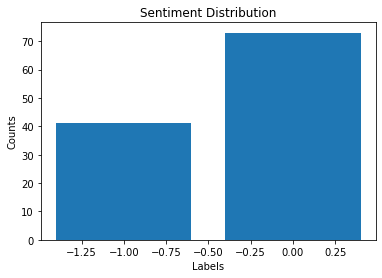

In [108]:
# Distribusi sentimen dari data judul berita yang didapat
c = Counter(df_news["sentiment"])

plt.bar(c.keys(), c.values())
plt.title(f'Sentiment Distribution')
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.show()

In [109]:
pos = df_news[df_news['sentiment']==1]['clean_news']
positive_title = [word for title in pos.apply(lambda x: word_tokenize(str(x))) for word in title]

pd.Series(nltk.ngrams(positive_title, 2)).value_counts()[:5]

Series([], dtype: int64)

In [110]:
net = df_news[df_news['sentiment']==0]['clean_news']
neutral_title = [word for title in net.apply(lambda x: word_tokenize(str(x))) for word in title]

pd.Series(nltk.ngrams(neutral_title, 2)).value_counts()[:5]

(tuntut, bui)           14
(putri, candrawathi)     8
(hukum, mati)            7
(bocor, vonis)           6
(jaksa, tuntut)          4
dtype: int64

In [111]:
neg = df_news[df_news['sentiment']==-1]['clean_news']
negative_title = [word for title in neg.apply(lambda x: word_tokenize(str(x))) for word in title]

pd.Series(nltk.ngrams(negative_title, 2)).value_counts()[:5]

(keluarga, yosua)    14
(bunuh, yosua)        7
(nilai, tuntut)       5
(yosua, kecewa)       5
(tuntut, bui)         5
dtype: int64

# 5. Data Analysis

## Sentimen analisis (ML)
Model yang dihasilkan memiliki skor akurasi sekitar 0.68. Hasil ini cukup baik meskipun sebenarnya dapat ditingkatkan. Untuk prediksi yang dihasilkan, kebanyakan hasil adalah negatif dan netral, tanpa ada positif satupun

Beberapa hal yang perlu diperhatikan dalam penggunaan model ini adalah:
1. Label sentimen yang digunakan di-generate secara otomatis menggunakan kamus bahasa. Hal ini tentu saja dapat menjadi perhatian karena masih memungkinkan kesalahan pelabelan yang dilakukan oleh mesin. Sebagai contoh, tweet yang sebenarnya memiliki sentimen positif namun menggunakan kata-kata yang negatif tentu saja akan dilabeli negatif. Begitu pula sebaliknya. Pelabelan secara manual oleh manusia tentu lebih diinginkan.
2. Perbedaan data train dan data test. Data train merupakan data tweet dari Twitter yang bersifat lebih bebas dan terdapat opini dari publik. Sedangkan data test merupakan data berita dari media massa yang lebih terstruktur dan terorganisir. 
3. Ketimpangan label data train dimana lebih banyak label sentimen negatif dan netral.